# V10 - Otros usos de aprendizaje no-supervisado


El notebook de esta clase va a ser un poco diferente de los anteriores. En este caso vamos a ver dos ejemplos independientes de aprendizaje no-supervisado que no ha dado tiempo a ver en clase. El primero va a ser el uso de grafos para segmentación, y el segundo, el uso de modelos generativos adversarios para generación de contenido.

## Segmentación mediante grafos

Este algoritmo construye primero un grafo de adyacencia de regiones y luego realiza el corte mínimo normalizado. En fuentes podéis conocer más sobre cómo funciona el agoritmo. 

Vamos a ver un ejemplo:

In [ ]:
!pip install scikit-image==0.16.2

     |████████████████████████████████| 26.5 MB 56.2 MB/s 
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.18.3
    Uninstalling scikit-image-0.18.3:
      Successfully uninstalled scikit-image-0.18.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


### Corte normalizado

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  del sys.path[0]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipp

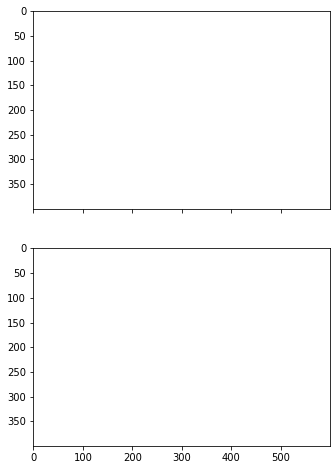

In [ ]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt


img = data.coffee()

labels1 = segmentation.slic(img, compactness=30, n_segments=400)
out1 = color.label2rgb(labels1, img, kind='avg')

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg')

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

### GrabCut:

En este ejemplo vamos a ver cómo podemos usar el corte mínimo de un grafo para segmentar background de foreground en una imagen.

Pongamos como ejemplo esta imagen:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/grabcut_output1.jpg">

Como podéis ver, disponemos de una bounding box y de semillas para background y para foreground.

Lo que hace el algoritmo de GrabCut es construir un grafo asignando todos los pixels o bien a una fuente a un sumidero, y después encuentra el mínimo corte en dicho grafo:

<img src="https://opencv24-python-tutorials.readthedocs.io/en/latest/_images/grabcut.jpg">

Tenemos la suerte de que este algoritmo se encuentra implementado en OpenCV: `cv2.grabCut()`. Veamos sus argumentos.

`img` - Input image

`mask` - It is a mask image where we specify which areas are background, foreground or probable background/foreground etc. It is done by the following flags, cv2.GC_BGD, cv2.GC_FGD, cv2.GC_PR_BGD, cv2.GC_PR_FGD, or simply pass 0,1,2,3 to image.

`rect` - It is the coordinates of a rectangle which includes the foreground object in the format (x,y,w,h)

`bdgModel, fgdModel` - These are arrays used by the algorithm internally. You just create two np.float64 type zero arrays of size (1,65).

`iterCount` - Number of iterations the algorithm should run.

`mode` - It should be cv2.GC_INIT_WITH_RECT or cv2.GC_INIT_WITH_MASK or combined which decides whether we are drawing rectangle or final touchup strokes.

First let’s see with rectangular mode. We load the image, create a similar mask image. We create fgdModel and bgdModel. We give the rectangle parameters. It’s all straight-forward. Let the algorithm run for 5 iterations. Mode should be cv2.GC_INIT_WITH_RECT since we are using rectangle. Then run the grabcut. It modifies the mask image. In the new mask image, pixels will be marked with four flags denoting background/foreground as specified above. So we modify the mask such that all 0-pixels and 2-pixels are put to 0 (ie background) and all 1-pixels and 3-pixels are put to 1(ie foreground pixels). Now our final mask is ready. Just multiply it with input image to get the segmented image.

In [ ]:
!wget https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg

--2021-10-07 19:34:21--  https://raw.githubusercontent.com/abidrahmank/OpenCV2-Python-Tutorials/master/data/messi5.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72937 (71K) [image/jpeg]
Saving to: ‘messi5.jpg’

messi5.jpg          100%[===================>]  71.23K  --.-KB/s    in 0.01s   

2021-10-07 19:34:22 (5.49 MB/s) - ‘messi5.jpg’ saved [72937/72937]



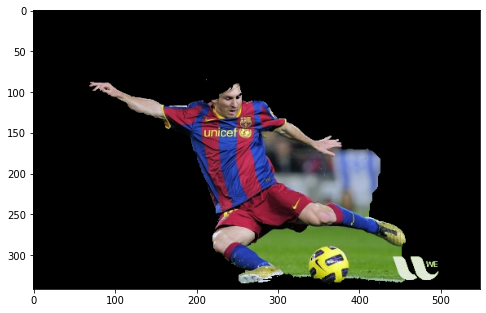

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [8, 8]

img_orig = cv2.imread('messi5.jpg')
mask = np.zeros(img_orig.shape[:2],np.uint8)

bgdModel = np.zeros((1,65),np.float64)
fgdModel = np.zeros((1,65),np.float64)

rect = (50,50,450,290)
cv2.grabCut(img_orig, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask2[:,:,np.newaxis]

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Fijaos que el pelo y el cesped entre las piernas no se ha segmentado bien. ¿Cómo podemos arreglarlo?

In [ ]:
!wget -O newmask.png https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG&s

/bin/bash: s: command not found
--2021-10-07 19:36:22--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ6doDpZUR3q0TeUQyjBUc_dB-N6xBfCnNOp4SbxDumtKDB_1TG
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 173.194.218.100, 173.194.218.101, 173.194.218.138, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|173.194.218.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2798 (2.7K) [image/png]
Saving to: ‘newmask.png’

newmask.png         100%[===================>]   2.73K  --.-KB/s    in 0s      

2021-10-07 19:36:22 (21.6 MB/s) - ‘newmask.png’ saved [2798/2798]



(<matplotlib.image.AxesImage at 0x7fec65cfad10>,
 <matplotlib.image.AxesImage at 0x7fec65d06150>)

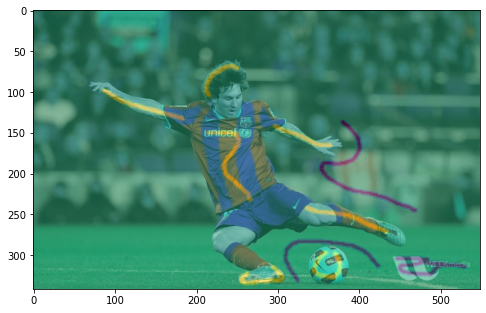

In [ ]:
# newmask is the mask image I manually labelled
newmask = cv2.imread('newmask.png',0)
newmask = cv2.resize(newmask, img.shape[:2][::-1])
plt.imshow(img_orig), plt.imshow(newmask, alpha=0.5)

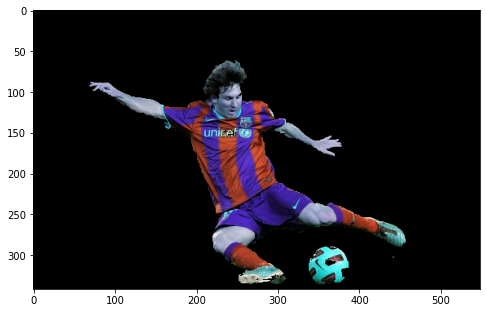

In [ ]:
# whereever it is marked white (sure foreground), change mask=1
# whereever it is marked black (sure background), change mask=0
mask[newmask == 0] = 0
mask[newmask == 255] = 1

mask, bgdModel, fgdModel = cv2.grabCut(img_orig,mask,None,bgdModel,fgdModel,5,cv2.GC_INIT_WITH_MASK)

mask = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img_orig*mask[:,:,np.newaxis]
plt.imshow(img)

Y afinando más la máscara, podríamos llegar a obtener perfectamente a Messi sin nada de fondo.

### Fuentes:

- https://scikit-image.org/docs/0.16.x/auto_examples/segmentation/plot_ncut.html?highlight=normalized%20cut
- https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_grabcut/py_grabcut.html

### Recursos interesantes:

- https://medium.com/stellargraph/knowing-your-neighbours-machine-learning-on-graphs-9b7c3d0d5896

## Generando contenido con GANs

Las "Generative Adversarial Networks" son un tipo de redes neuronales que han ganado mucha popularidad en los últimos años debido a su capacidad para generar contenido nuevo de alta calidad.

La idea es realmente sencilla:

<img src="http://2018.igem.org/wiki/images/4/48/T--Vilnius-Lithuania-OG--introduction1.png">

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from IPython.display import Image,display

#X and Z will have the real data and generated data respectlvely
X = tf.placeholder(tf.float32, shape=[None, 784])
Z = tf.placeholder(tf.float32, shape=[None, 100])

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

TensorFlow 1.x selected.


In [ ]:
def generator(z):
    
    with tf.variable_scope("generator"):
        
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs=z,units=128,activation=tf.nn.relu, kernel_initializer=init,use_bias=True)
        out = tf.layers.dense(inputs=h1,units=784,activation=tf.nn.tanh, kernel_initializer=init,use_bias=True)         

        return out

def discriminator(x):
    
    with tf.variable_scope("discriminator",reuse=tf.AUTO_REUSE):
        
        init = tf.contrib.layers.xavier_initializer()
        h1 = tf.layers.dense(inputs=x,units=128,activation=tf.nn.relu, kernel_initializer=init,use_bias=True)
        logits = tf.layers.dense(inputs=h1,units=1, kernel_initializer=init,use_bias=True)

        return logits

def sample_Z(r, c):
    return np.random.uniform(-1., 1., size=[r, c])

G_sample = generator(Z)
logits_real = discriminator(X)
logits_fake = discriminator(G_sample)
print(G_sample.shape, X.shape)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 784) (?, 784)


In [ ]:
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_real),
                                                                     logits=logits_real))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(logits_fake),
                                                                     logits=logits_fake))
D_loss = D_loss_real +D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(logits_fake),
                                                                logits=logits_fake))

# Actual loss code for the equations but above is the better version 
D_real = tf.nn.sigmoid(logits_real)
D_fake = tf.nn.sigmoid(logits_fake)

D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(D_loss, var_list=D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate=1e-3,beta1=0.5).minimize(G_loss, var_list=G_vars)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../../MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ../../MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting ../../MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting ../../MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as offi

Initial generated images


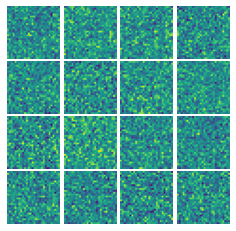

In [ ]:
print("Initial generated images")
samples = sess.run(G_sample,feed_dict={Z: sample_Z(128, 100)})
fig = show_images(samples[:16])
plt.show()
print()

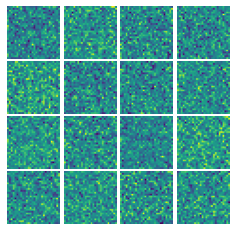


Iter: 0
D loss: 1.217
G_loss: 0.7516



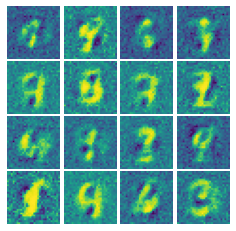


Iter: 1000
D loss: 1.018
G_loss: 1.845



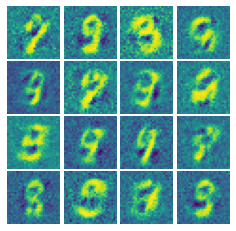


Iter: 2000
D loss: 1.18
G_loss: 1.066



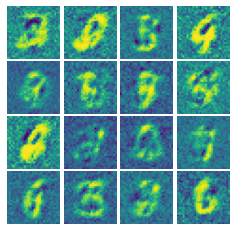


Iter: 3000
D loss: 0.9803
G_loss: 1.639



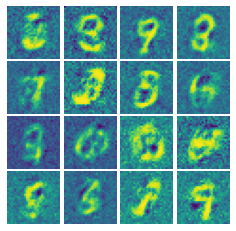


Iter: 4000
D loss: 1.051
G_loss: 1.071



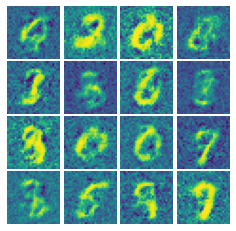


Iter: 5000
D loss: 1.212
G_loss: 1.147



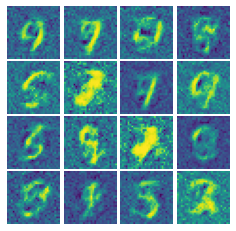


Iter: 6000
D loss: 1.132
G_loss: 1.21



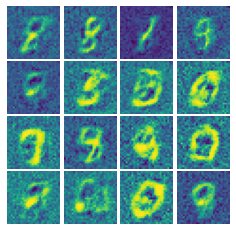


Iter: 7000
D loss: 1.616
G_loss: 1.478



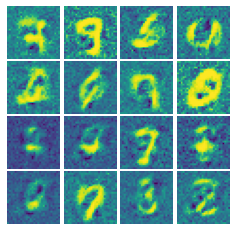


Iter: 8000
D loss: 1.18
G_loss: 1.525



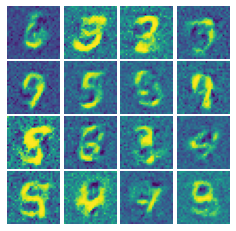


Iter: 9000
D loss: 1.151
G_loss: 1.282



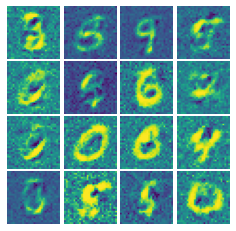


Iter: 10000
D loss: 1.16
G_loss: 1.071



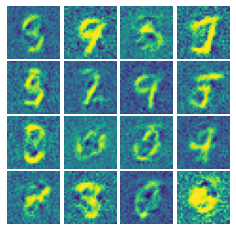


Iter: 11000
D loss: 1.052
G_loss: 1.426



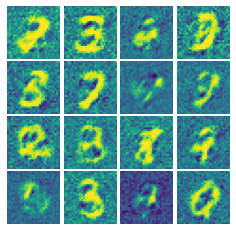


Iter: 12000
D loss: 1.208
G_loss: 1.238



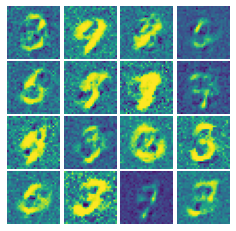


Iter: 13000
D loss: 1.233
G_loss: 1.103



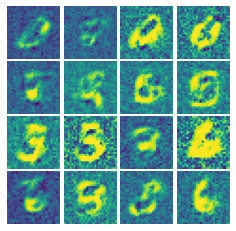


Iter: 14000
D loss: 0.909
G_loss: 1.253



In [ ]:
for it in range(15000):
    
    if it % 1000 == 0:
        samples = sess.run(G_sample,feed_dict={Z: sample_Z(128, 100)})
        fig = show_images(samples[:16])
        plt.show()
        print()
        
    x, _ = mnist.train.next_batch(128)
    _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: x, Z: sample_Z(128, 100)})
    _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: sample_Z(128, 100)})
    
    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print()

### Fuentes

- https://github.com/Madhu009/Deep-math-machine-learning.ai/blob/master/Gan's/vanillaGAN.ipynb

### Recursos

- https://github.com/Madhu009/Deep-math-machine-learning.ai/tree/master/Gan's
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://machinelearningmastery.com/resources-for-getting-started-with-generative-adversarial-networks/
- https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f
- http://ganocracy.csail.mit.edu/tutorial/tutorial.html
- https://poloclub.github.io/ganlab/
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
- https://danieltakeshi.github.io/2017/03/05/understanding-generative-adversarial-networks/
- http://www.gatsby.ucl.ac.uk/~balaji/Understanding-GANs.pdf
- https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

### Trabajos interesantes

- https://medium.com/syncedreview/gan-2-0-nvidias-hyperrealistic-face-generator-e3439d33ebaf
- https://github.com/NVIDIA/vid2vid